<center><h1> <font color="green"><u>Active-Case Predictions ~ 19-nCoV</u></font> </h1></center>

<center><h3> <font color="#cc0000"><u>Active Cases(%) out of Confirmed</u></font> </h3></center>

<h3> <font color="purple"><u>This section includes:</u></font> </h3>

> * Data Filtering <br />
> * Training & Testing datasets <br />
> * Prediction <br />
> * Visualization (Scatter Plots) <br />

<br />

## Creating Datasets

In [1]:
# setting the working directory
setwd("~/Documents/A-tracking-of-2019-nCoV/COVID-19/ready_to_use")

In [3]:
# Loading desired libraries
library(ggplot2)
library(stringr)

# loading plotting/machine learning
library(tidyverse)
library(caret)
library(mlbench)
library(kernlab)
library(rpart)

<hr />

In [82]:
# includes data of all the countries
all = read.csv('COVID-19/Mixed/countryWise_bulk_summary.csv')

# includes data of four majour location
three = read.csv('COVID-19/THREE/Three_dataset_locationWise.csv')
#all
#three

In [83]:

# extracting the desired dataset
extractDatases <- function(region){
    if(region %in% c("Hubei", "World")) {
    temp = three[which(str_detect(three$Location, region)),]
    row.names(temp) <- NULL
} else {
    temp = all[which(str_detect(all$Country, region)),]
    row.names(temp) <- NULL
}

return(temp)
}


In [84]:
# country list
countries = matrix(levels(as.factor(all$Country)))
#head(countries, 10)

# Four majour locations
locations = matrix(levels(as.factor(four$Location)))
#locations

<br /> 
### Choosing desired Country/Region

In [85]:
# country i.e. to be used throughout the analysis
 rName = "China" # without hubei

# some other possible values of rName:
# 'World', 'Hubei', 'Diamond Cruise', 'Italy', 'Japan'.....etc

<hr />

In [86]:
# filtering out desired country/location 
if(rName == "China"){
    region1 = extractDatases(rName)

    # joining Hubei for complete data of china
    region2 = extractDatases("Hubei")

    region = cbind(region1[,1:3], region1[,4:7]+region2[,4:7])
    colnames(region) <- colnames(region1)
} else {
    region = extractDatases(rName)
}

tail(region)

,Country,Day,Date,Confirmed,Deaths,Active.Cases,Closed.Cases
69,China,69,30-03-2020,82199,3308,78891,3308
70,China,70,31-03-2020,82280,3309,78971,3309
71,China,71,01-04-2020,82362,3316,79046,3316
72,China,72,02-04-2020,82433,3322,79111,3322
73,China,73,03-04-2020,82512,3326,79186,3326
74,China,74,04-04-2020,82544,3330,79214,3330


<hr />

In [87]:
region=region[,c(2, 4:7)]
head(region, 10)

Day,Confirmed,Deaths,Active.Cases,Closed.Cases
1,548,17,531,17
2,643,18,625,18
3,920,26,894,26
4,1406,42,1364,42
5,2075,56,2019,56
6,2877,82,2795,82
7,5509,131,5378,131
8,6087,133,5954,133
9,8141,171,7970,171
10,9802,213,9589,213


In [88]:
# calculate the percent (using Confirmed cases as total)
percent <- function(dfName){
    get(dfName) -> df
    part <- NULL
    
    for(i in 1:nrow(df)) {
        val = df[i,"Active.Cases"]
        Total = df[i,"Confirmed"]
        
        
        if(i == 1)
            if(val==0)
                part = 0
            else
                part = as.numeric((val*100)/Total)
        else
            if(val==0)
                part = c(part, 0)
            else
                part <- c(part, as.numeric((val*100)/Total))
    }
        
    return(part)
}

<hr />

In [89]:
# CASES -> percentage
region$'percent_active' = percent("region")     # Active cases, out of every 100 Confirmed cases
region$'percent_closed' = 100-percent("region") # Closed cases, out of every 100 Confirmed cases

In [90]:
tail(region)

,Day,Confirmed,Deaths,Active.Cases,Closed.Cases,percent_active,percent_closed
69,69,82199,3308,78891,3308,95.97562,4.024380
70,70,82280,3309,78971,3309,95.97837,4.021633
71,71,82362,3316,79046,3316,95.97387,4.026129
72,72,82433,3322,79111,3322,95.97006,4.029939
73,73,82512,3326,79186,3326,95.96907,4.030929
74,74,82544,3330,79214,3330,95.96579,4.034212


In [91]:
#write.csv(region, file = "COVID-19/regionToPredictActive.csv")

<br />* Dataset is ready

<hr /><br />

### Understanding the plot

Warning message:
“Use of `region$Day` is discouraged. Use `Day` instead.”
Warning message:
“Use of `region$percent_active` is discouraged. Use `percent_active` instead.”


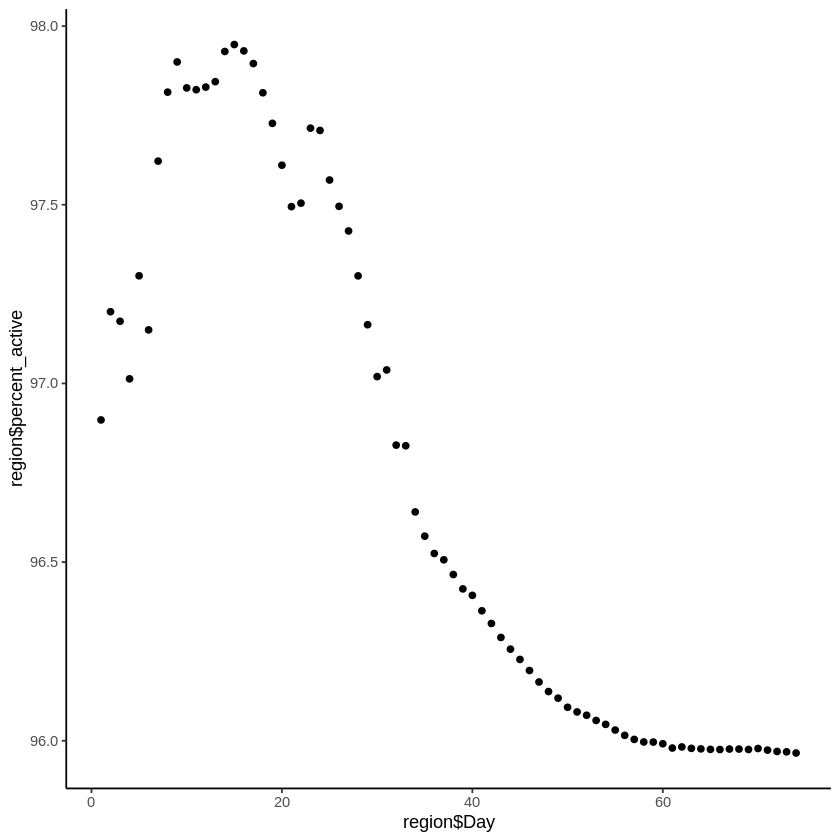

In [92]:
# Day vs %Closed Cases
region.scatter.plot <- ggplot(region, aes(x = region$Day, y = region$percent_active)) +
                        geom_point()
region.scatter.plot

In [93]:
tail(region)

,Day,Confirmed,Deaths,Active.Cases,Closed.Cases,percent_active,percent_closed
69,69,82199,3308,78891,3308,95.97562,4.024380
70,70,82280,3309,78971,3309,95.97837,4.021633
71,71,82362,3316,79046,3316,95.97387,4.026129
72,72,82433,3322,79111,3322,95.97006,4.029939
73,73,82512,3326,79186,3326,95.96907,4.030929
74,74,82544,3330,79214,3330,95.96579,4.034212


<br /><hr /><br />

## Data-Analysis <br />

In [94]:
# setting the theme
theme_set(theme_classic())
temp = region[c(70:74),]
region = region[-c(70:74),]
temp

,Day,Confirmed,Deaths,Active.Cases,Closed.Cases,percent_active,percent_closed
70,70,82280,3309,78971,3309,95.97837,4.021633
71,71,82362,3316,79046,3316,95.97387,4.026129
72,72,82433,3322,79111,3322,95.97006,4.029939
73,73,82512,3326,79186,3326,95.96907,4.030929
74,74,82544,3330,79214,3330,95.96579,4.034212


In [95]:
set.seed(20) # generages same set of random sample every time

training.samples <- region$Day %>%
  createDataPartition(p = 0.8, list = FALSE)

train.data  <- region[training.samples, ]
test.data <- region[-training.samples, ]

In [96]:
tail(train.data, 3)
head(test.data, 3)

,Day,Confirmed,Deaths,Active.Cases,Closed.Cases,percent_active,percent_closed
67,67,82000,3299,78701,3299,95.97683,4.023171
68,68,82123,3304,78819,3304,95.97677,4.023233
69,69,82199,3308,78891,3308,95.97562,4.024380


,Day,Confirmed,Deaths,Active.Cases,Closed.Cases,percent_active,percent_closed
10,10,9802,213,9589,213,97.82697,2.173026
17,17,34110,718,33392,718,97.89505,2.104955
18,18,36814,805,36009,805,97.81333,2.186668


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



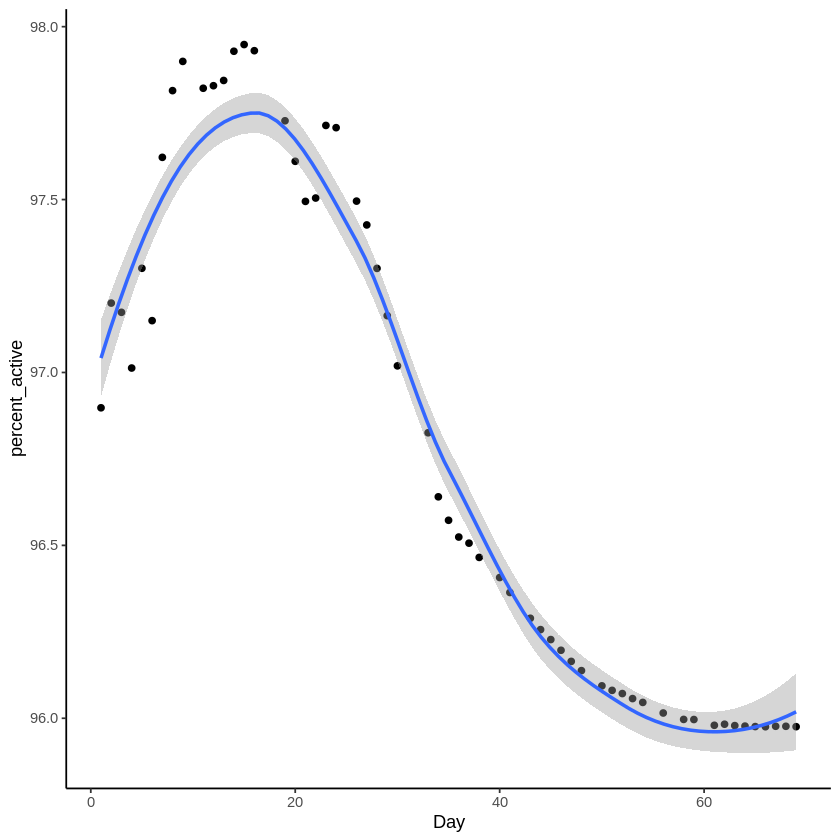

In [97]:
ggplot(train.data, aes(Day, percent_active) ) +
  geom_point() +
  stat_smooth()

<br /><hr /><br />

## Regrassion

### 1. Linear regression

In [98]:
# building linear model
fit.lm = lm(Day ~ percent_active, data = train.data)
#summary(fit.lm)

In [99]:
#Residual Standard error (Like Standard Deviation)
k=length(fit.lm$coefficients)-1
#Multiple R-Squared (Coefficient of Determination)
SSyy=sum((train.data$percent_active-mean(train.data$percent_active))**2)
    
SSE=sum(fit.lm$residuals**2)
n=length(fit.lm$residuals)
    
# final
rmse = sqrt(SSE/(n-1))
rse = sqrt(SSE/(n-(1+k))) #Residual Standard Error
r2 = (SSyy-SSE)/SSyy


# Model performance
data.frame(
       RMSE = rmse,
       RSE = rse,
       R2 = r2
     )

RMSE,RSE,R2
9.858987,9.94821,-182.7604


<br />

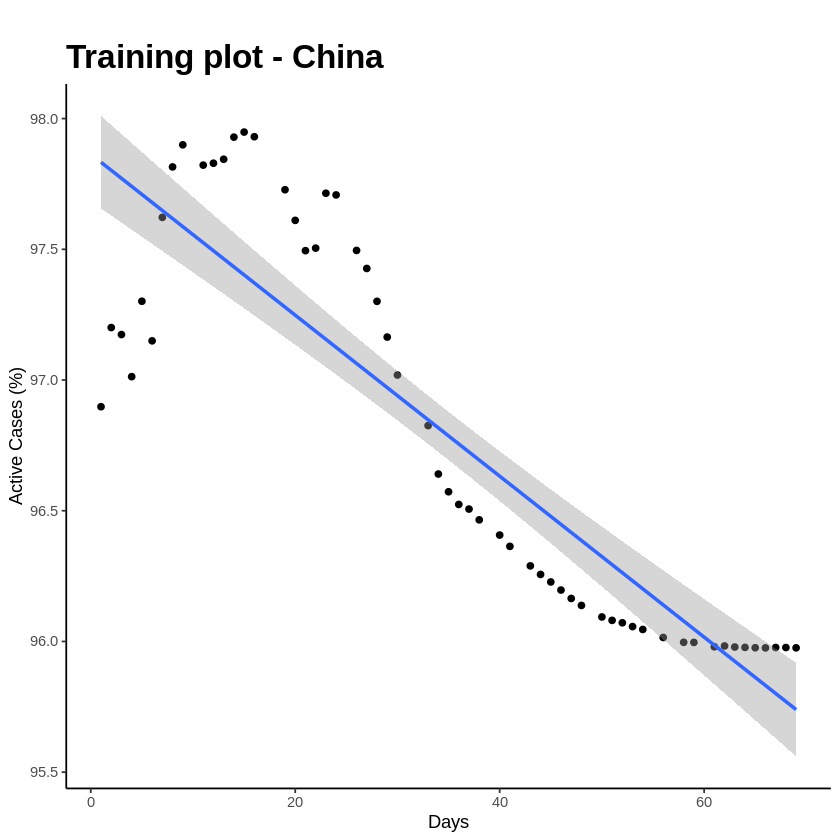

In [100]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

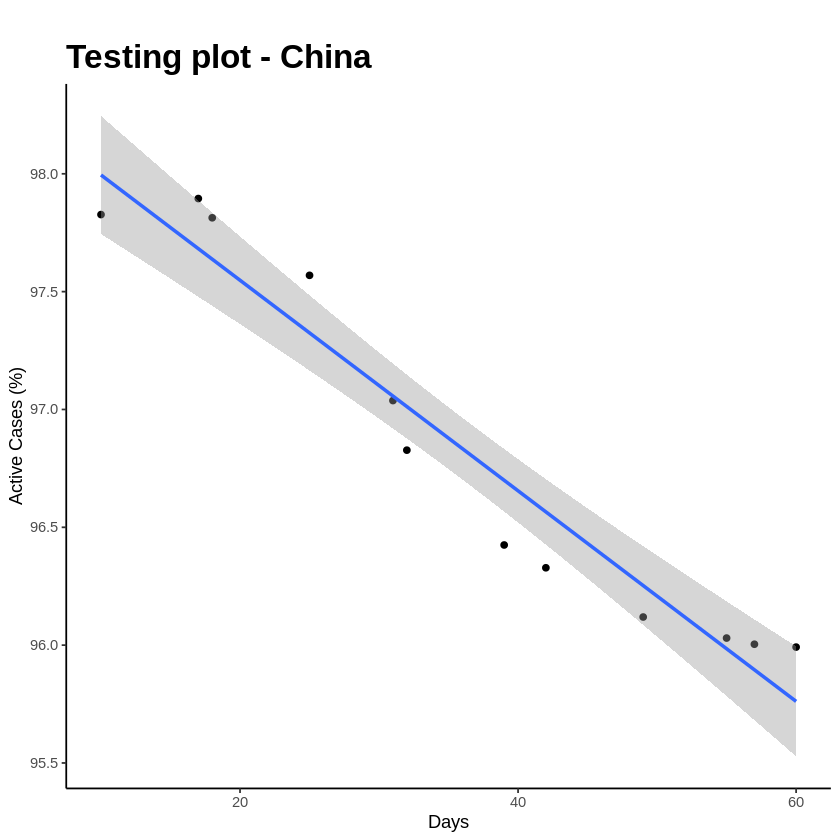

In [101]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br />

In [102]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.lm, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.lm, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
65,65,95.97594,55.34799
66,66,95.97548,55.35944
67,67,95.97683,55.32550
68,68,95.97677,55.32708
69,69,95.97562,55.35595


,Day,percent_active,Pridicted_percent_active
42,42,96.32823,46.47509
49,49,96.11928,51.73778
55,55,96.03001,53.98602
57,57,96.00385,54.64503
60,60,95.99169,54.95132


<br />

### 2. Polynomial regression

In [155]:
# Model performance
plm.predictions = data.frame(
  Degree = NULL,
  RMSE = NULL,
  RSE = NULL,
  R2 = NULL
)


for(deg in 1:20){
    
    # building polynomial model
    fit.plm = lm(percent_active ~ poly(Day, deg, raw = TRUE), data = train.data)
    #summary(fit.plm)

    
    #Residual Standard error (Like Standard Deviation)
    k=length(fit.plm$coefficients)-1
    #Multiple R-Squared (Coefficient of Determination)
    SSyy=sum((train.data$percent_active-mean(train.data$percent_active))**2)
    
    SSE=sum(fit.plm$residuals**2)
    n=length(fit.plm$residuals)
    
    
    # final
    rmse = sqrt(SSE/(n-1))
    rse = sqrt(SSE/(n-(1+k))) #Residual Standard Error
    r2 = (SSyy-SSE)/SSyy
    
    temp <- data.frame(
                        Degree = deg,
                        RMSE = rmse,
                        RSE = rse,
                        R2 = r2
                      )
    
    plm.predictions = rbind(plm.predictions, temp)
}

plm.predictions#[which(plm.predictions$RMSE == min(plm.predictions$RMSE)),]

Degree,RMSE,RSE,R2
1,0.34468993,0.34780936,0.7753820
2,0.33854266,0.34475497,0.7833224
3,0.16211913,0.16664425,0.9503115
4,0.10538762,0.10936590,0.9790026
5,0.10322490,0.10816665,0.9798555
6,0.09476743,0.10029242,0.9830213
7,0.09443127,0.10095127,0.9831415
8,0.09435412,0.10191410,0.9831690
9,0.09036629,0.09863965,0.9845617
10,0.08747270,0.09651340,0.9855345


In [104]:
temp = data.frame( Degree = NULL, RMES = NULL, R2 = NULL)

for(dg in 1:20){
    model = lm(percent_active ~ poly(Day, dg, raw = TRUE), data = train.data)
    
    t = predict(model, train.data)

    # Model performance
    t2 = data.frame(
          Degree = dg,
          RMSE = RMSE(t, train.data$Day),
          R2 = R2(t, train.data$Day)
        )
    
    temp = rbind(temp, t2)
}
temp

Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”


Degree,RMSE,R2
1,65.59610,1.0000000
2,65.59613,0.9898633
3,65.59679,0.8159241
4,65.59690,0.7920123
5,65.59691,0.7913228
6,65.59692,0.7887744
7,65.59692,0.7886780
8,65.59692,0.7886559
9,65.59692,0.7875404
10,65.59693,0.7867629


In [166]:
deg = 10  # degree of polynomial # 11 is far better then 16

# building polynomial model
fit.plm = lm(percent_active ~ poly(Day, deg, raw = TRUE), data = train.data)
#summary(model)

In [167]:
p = predict(fit.plm, train.data)

# Model performance
data.frame(
  RMSE = RMSE(p, train.data$Day),
  R2 = R2(p, train.data$Day)
)

RMSE,R2
65.59693,0.7867629


<br />

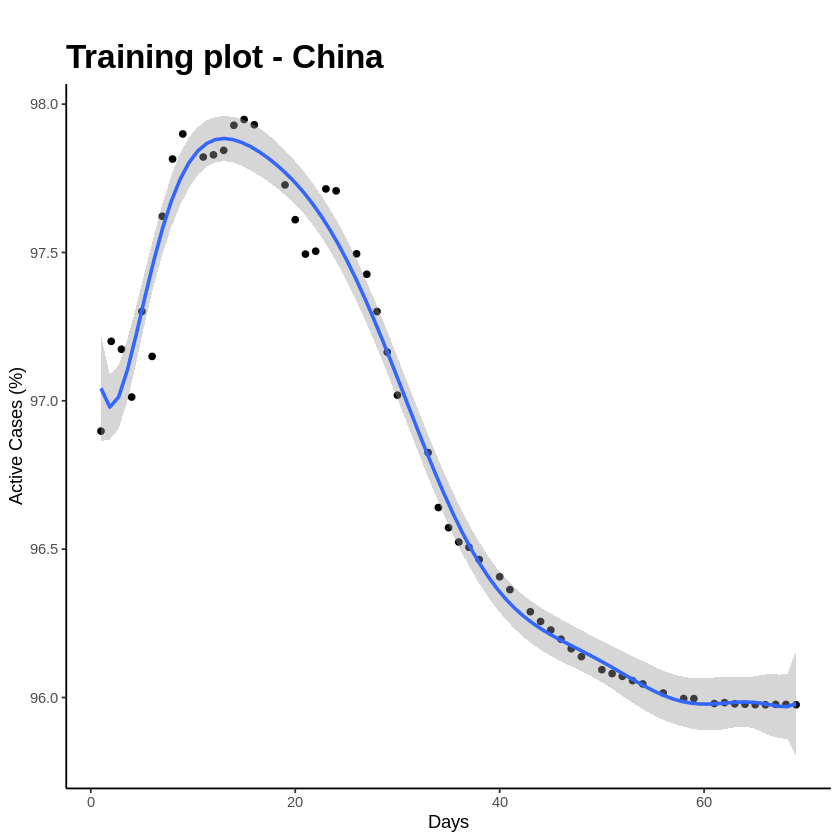

In [168]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

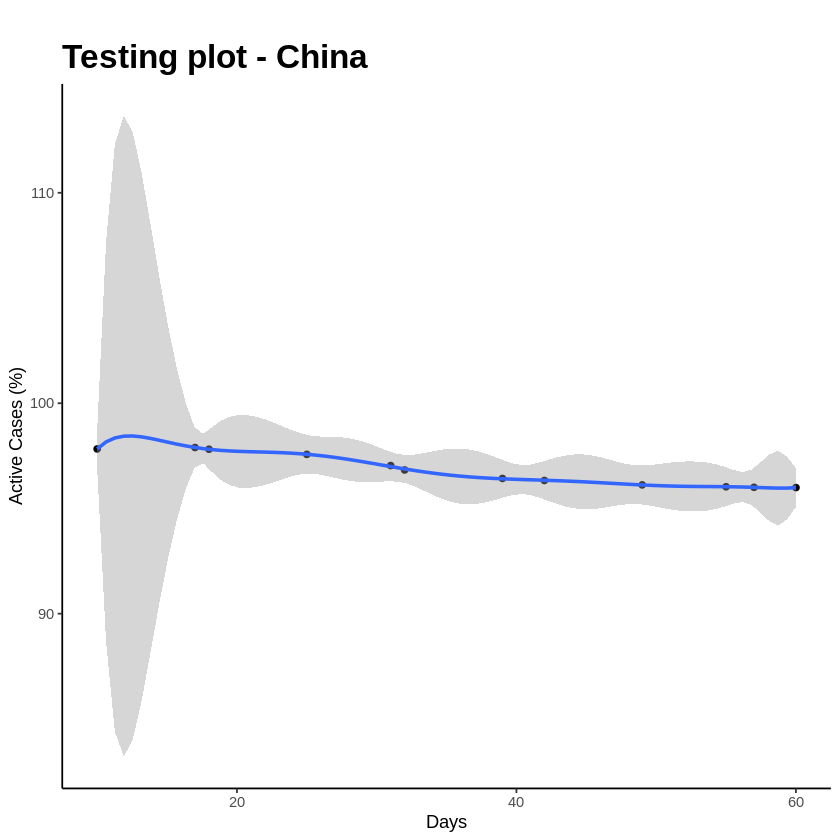

In [169]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br /><br />

In [144]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.plm, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.plm, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
65,65,95.97594,95.98655
66,66,95.97548,96.00336
67,67,95.97683,96.01096
68,68,95.97677,95.99579
69,69,95.97562,95.93809


,Day,percent_active,Pridicted_percent_active
42,42,96.32823,96.27009
49,49,96.11928,96.13217
55,55,96.03001,96.05312
57,57,96.00385,96.01305
60,60,95.99169,95.96111


<br /> 
### 3. SVMK Regression

In [145]:
# model
fit.svmk <- ksvm(percent_active~Day, train.data, kernel="rbfdot")
#summary(fit.svmk)

In [146]:
predictions <- fit.svmk %>% predict(train.data)

In [147]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
65.61498,0.7896169


<br />

In [148]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.svmk, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.svmk, test.data)
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
65,65,95.97594,96.01845
66,66,95.97548,96.01015
67,67,95.97683,96.00903
68,68,95.97677,96.02024
69,69,95.97562,96.04804


,Day,percent_active,Pridicted_percent_active
42,42,96.32823,96.39423
49,49,96.11928,96.18699
55,55,96.03001,96.09920
57,57,96.00385,96.07782
60,60,95.99169,96.05673


<br />

`geom_smooth()` using formula 'y ~ x'



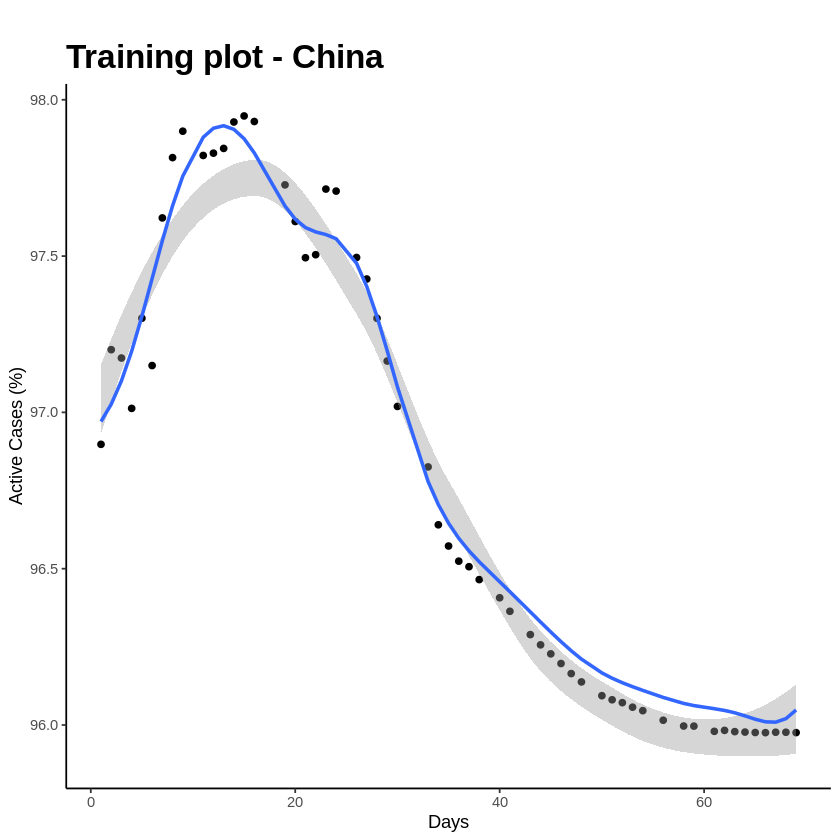

In [149]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=trained, method="loess", size=0) +
              geom_line(data = trained, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

`geom_smooth()` using formula 'y ~ x'



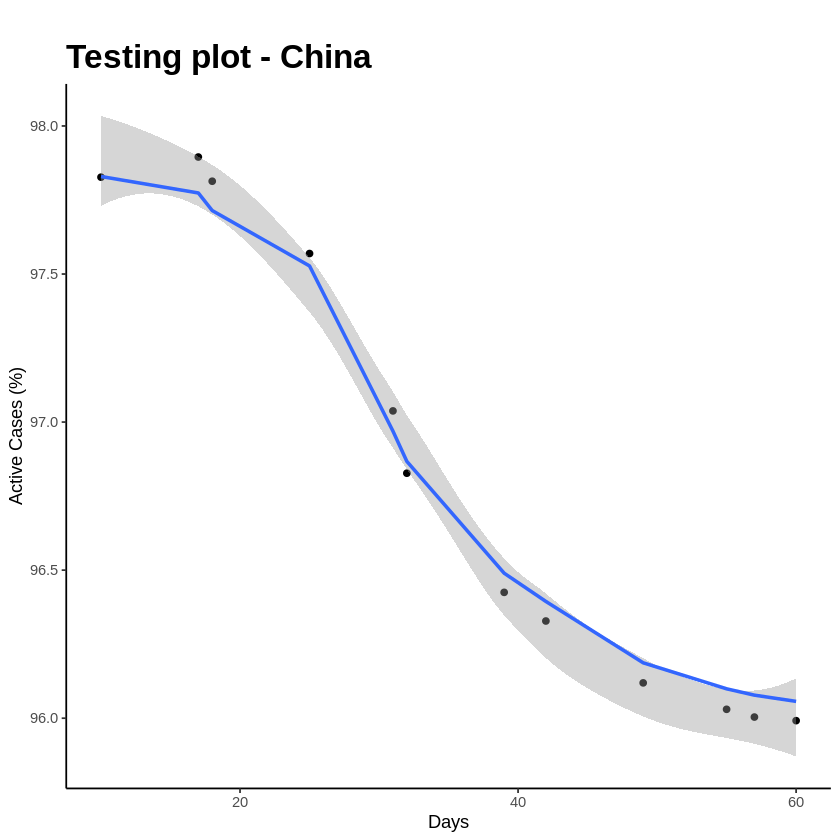

In [150]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = tested, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br /> 
### 4. KNN Regression

In [132]:
x <- as.matrix(train.data[,1])
y <- as.matrix(train.data[,7])

In [133]:
# fit model
fit.knn <- knnreg(x, y, k=2)
#summary(fit.knn)

In [134]:
predictions <- fit.knn %>% predict(x)

In [135]:
data.frame(
  RMSE = RMSE(predictions, x),
  R2 = R2(predictions, x)
)

RMSE,R2
37.33193,0.7866134


<br />

In [136]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.knn, as.matrix(train.data[,1]))
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_active")],
            Pridicted_percent_active = predict(fit.knn, as.matrix(test.data[,1]))
         )


tail(trained, 5)
tail(tested, 5)

,Day,percent_active,Pridicted_percent_active
65,65,95.97594,4.023754
66,66,95.97548,4.023918
67,67,95.97683,4.023641
68,68,95.97677,4.023595
69,69,95.97562,4.023807


,Day,percent_active,Pridicted_percent_active
42,42,96.32823,3.673582
49,49,96.11928,3.884255
55,55,96.03001,3.969488
57,57,96.00385,3.994076
60,60,95.99169,4.011989


<br />

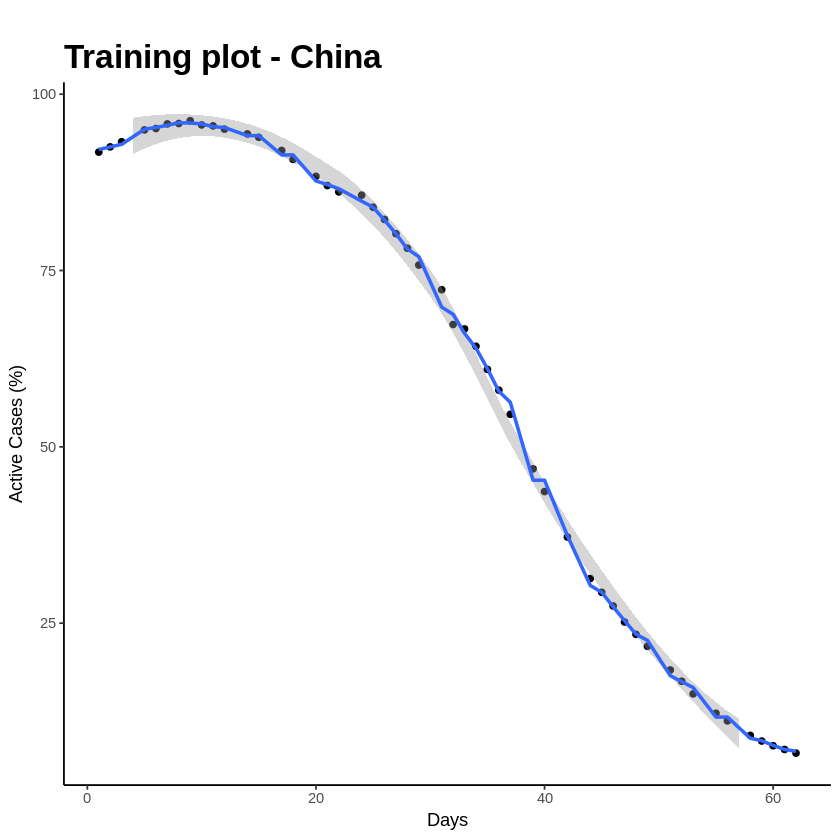

In [41]:
trainer <- ggplot(train.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = trained, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

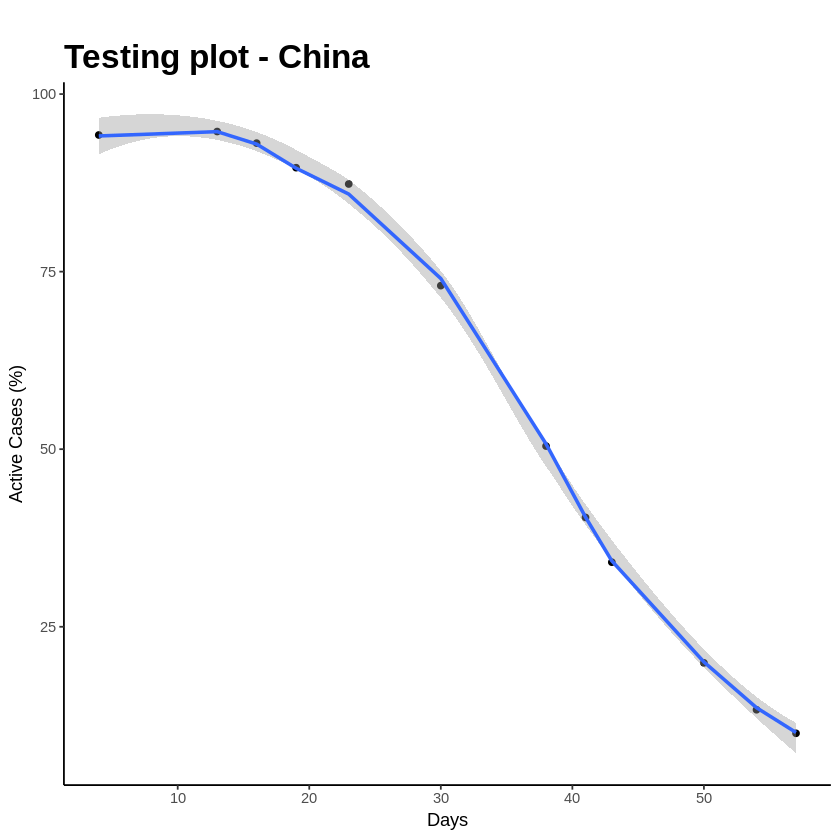

In [42]:
tester <- ggplot(test.data, aes(Day, percent_active) ) +
              geom_point() +
              geom_smooth(data=tested, method="loess", size=0) +
              geom_line(data = tested, aes(Day, Pridicted_percent_active), color="#3366fe", size=1) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Active Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

<br />

<br /><hr /><br />

## Predictions

In [170]:
test_Miscellaneous = data.frame(
                        Day = rep(NaN, 18),
                        #Confirmed = NaN,
                        #Active.Cases = NaN,
                        percent_active = 8.2854
                        #percent_closed = NaN
                     )

In [171]:
# 13th March ---> day 52
dNo = c(62:79)    # get the day no. to pridict

test_Miscellaneous$'Day' = dNo

test_Miscellaneous

Day,percent_active
62,8.2854
63,8.2854
64,8.2854
65,8.2854
66,8.2854
67,8.2854
68,8.2854
69,8.2854
70,8.2854
71,8.2854


<br /> 
2. #### By New Model

In [172]:
# modeling variable  --->  fit

Prediction = cbind(
                "Day" = 62:79,
                "Active (%)" = c(region[62:69,"percent_active"],rep(NaN, 10)),
                #"By SVMK M." = as.numeric(predict(fit.svmk, test_Miscellaneous)),
                #"By KNN M." = predict(fit.knn, as.matrix(test_Miscellaneous[,1])),
                "By Poly M." = predict(fit.plm, test_Miscellaneous),
                "By Linear M." = predict(fit.lm, test_Miscellaneous)
             )
Prediction

#train.data

Day,Active (%),By Poly M.,By Linear M.
62,95.98277,95.98108,2263.934
63,95.97877,95.98376,2263.934
64,95.97732,95.98495,2263.934
65,95.97594,95.98330,2263.934
66,95.97548,95.97846,2263.934
67,95.97683,95.97205,2263.934
68,95.97677,95.96899,2263.934
69,95.97562,95.97934,2263.934
70,NaN,96.02059,2263.934
71,NaN,96.12073,2263.934


In [76]:
class(predict(fit.knn, as.matrix(test_Miscellaneous[,1])))

[1] "numeric"

<br /> 
1. #### By Old Model

In [109]:
# modeling variable  --->  fit

Prediction = cbind(
                "Day" = 55:67,
                "Active (%)" = c(region[55:61,"percent_active"],rep(NaN, 7)),
                "By SVMK M." = as.numeric(predict(fit.svmk, test_Miscellaneous)),
                "By KNN M." = predict(fit.knn, as.matrix(test_Miscellaneous[,1])),
                "By Poly M." = predict(fit.plm, test_Miscellaneous),
                "By Linear M." = predict(fit.lm, test_Miscellaneous)
             )
Prediction

#train.data

Warning message in cbind(Day = 55:67, `Active (%)` = c(region[55:61, "percent_active"], :
“number of rows of result is not a multiple of vector length (arg 1)”


Day,Active (%),By SVMK M.,By KNN M.,By Poly M.,By Linear M.
55,12.224649,14.66001,11.682410,12.344438,58.60472
56,11.140171,12.99178,11.682410,11.028721,58.60472
57,9.995931,11.59714,10.112516,9.884036,58.60472
58,9.084860,10.66103,8.685148,8.962869,58.60472
59,8.285436,10.37194,8.327837,8.273719,58.60472
60,7.613214,10.89096,7.662835,7.726603,58.60472
61,7.089855,12.32159,7.351535,7.052953,58.60472
62,NaN,14.68679,7.351535,5.692816,58.60472
63,NaN,17.91896,7.351535,2.640982,58.60472
64,NaN,21.86518,7.351535,-3.757794,58.60472


<br /> 
3. #### By SVMK Model

In [69]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(fit.svmk, test_Miscellaneous)
             )
Prediction

Day,percent_active,percent_pridicted
55,8.2854,14.66001
56,8.2854,12.99178
57,8.2854,11.59714
58,8.2854,10.66103
59,8.2854,10.37194
60,8.2854,10.89096
61,8.2854,12.32159
62,8.2854,14.68679
63,8.2854,17.91896
64,8.2854,21.86518


<br /> 
3. #### By KNN Model

In [67]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_active")],
                percent_pridicted = predict(fit.knn, as.matrix(test_Miscellaneous[,1]))
             )
Prediction[]

Day,percent_active,percent_pridicted
55,8.2854,11.682410
56,8.2854,11.682410
57,8.2854,10.112516
58,8.2854,8.685148
59,8.2854,8.327837
60,8.2854,7.662835
61,8.2854,7.351535
62,8.2854,7.351535
63,8.2854,7.351535
64,8.2854,7.351535


<hr /> <br />

In [45]:
# world on day 58
# 92.63192 ---> @deg = 16
# 88.90763 ---> @deg = 19